In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Build the CVD training dataset
I need to load the core spreadsheet, and load the extra spreadsheet where required
Then I need to match the IDs. THen we have a spreadsheet that we can fit a logistic regression model with

In [2]:
CVD_core_df = pd.read_csv("umap_data_spreadsheets/CVD/clinscore_data.csv")

In [3]:
CVD_core_df

,Unnamed: 0.1,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,...,micrBld,smoking_0,smoking_1,smoking_2,total_fazekas,scale_fazekas,scale_pvs,scale_micrbld,stroke_les,scale_stroke
0,146,146,CVD247,1,68.0,2,0,1,1.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,NaN,1.0,1.0
1,134,134,CVD219,1,81.0,1,0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,1.0,NaN,1.0,0.0
2,131,131,CVD195,1,71.0,1,0,1,0.0,2.0,...,1.0,0.0,0.0,1.0,6.0,1.0,1.0,NaN,1.0,1.0
3,121,121,CVD173,1,68.0,1,0,1,0.0,2.0,...,0.0,0.0,0.0,1.0,4.0,1.0,0.0,NaN,1.0,0.0
4,104,104,CVD128,1,83.0,1,0,0,0.0,1.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,201,201,CVD302,1,55.0,1,0,1,0.0,2.0,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,NaN,1.0,1.0
246,138,138,CVD230,1,50.0,1,0,0,1.0,2.0,...,0.0,0.0,0.0,1.0,3.0,0.0,1.0,NaN,1.0,1.0
247,107,107,CVD132,1,56.0,1,0,0,0.0,2.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0
248,215,215,CVD316,1,78.0,1,0,1,1.0,2.0,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0


### Add the sample diversity data

In [4]:
sample_div_df = pd.read_csv("umap_data_spreadsheets/CVD/CHAL_BASED_sample_div_data_SSN_Ens.csv")

In [5]:
sample_div_df = sample_div_df.drop(columns="Unnamed: 0")

In [6]:
CVD_core_df = CVD_core_df.merge(sample_div_df, on="ID")
CVD_core_df = CVD_core_df.drop(columns="Unnamed: 0.1")
CVD_core_df = CVD_core_df.loc[CVD_core_df['dice'] > 0.005 ] # get rid of the examples where the image was broken when presented to the dataloader and resulted in dice of 0.

In [7]:
def load_model_output_stats(output_type, threshold, fields=None):
    df = pd.read_csv(f"umap_data_spreadsheets/CVD/CHAL_BASED_{output_type}_{threshold}.csv")
    if fields != None:
        return df[fields]
    return df

In [8]:
ent03 = load_model_output_stats("ent", 0.3)

In [9]:
ent03.keys()

Index(['Unnamed: 0', 'ID', 'cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_2

In [10]:
def merge_datasets(core_df, output_types, thresholds, selected_fields):
    for output_type, thresh, fields in zip(output_types, thresholds, selected_fields):
        
        extra_df = load_model_output_stats(output_type, thresh, fields) # load the specific output type at the given threshold, and select the desired fields
        
        extra_df = extra_df.rename(columns={key: f"{output_type}{thresh}_{key}" if key != 'ID' else 'ID' for key in extra_df.keys()}) # modify the column name so that we know which columns belong to which input type
        
        core_df = core_df.merge(extra_df, on="ID")
    
    core_df = core_df.drop(columns='ID')       
    
    return core_df

In [11]:
def remove_nans(dfc, verbose=False):
    nan_rows = dfc[dfc.isnull().any(axis=1)]
    nan_cols = dfc.columns[dfc.isnull().any()]
    if verbose:
        print("nans removed: ", len(nan_rows))
    dfc = dfc.drop(labels=nan_rows.index.values, axis=0)
    return dfc

In [12]:
def extract_Xy(df, label_class, verbose=False, kept_column=None, label_categories=None):
    df = remove_nans(df, verbose)
    if label_categories == None:
        label_categories = ['WMH', 'PVWMH', 'DWMH', 'deepAtrophy',
           'supAtrophy', 'BGPVS', 'CSPVS', 'total_fazekas', 'scale_fazekas',
           'scale_pvs', 'stroke_les', 'scale_stroke', 'dice',
           'f1', 'avd', 'recall']
    if kept_column != None:
        y_reg = df[kept_column].values
    y = df[label_class].values
    X = df.drop(columns=label_categories)
    if label_class not in label_categories:
        X = X.drop(columns=label_class)
    if kept_column != None:
        X[kept_column] = y_reg
    return X, y

### fitting to predict fazekas

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [14]:
class Rescaler():
    def fit(self, X):
        norm_parameters = []
        for key in X.keys():
            values = X[key].values
            if len(np.unique(values)) > 2:
                mean = np.mean(values)
                std = np.std(values)
                norm_parameters.append((key, mean, std))
        self.norm_parameters = norm_parameters
    def predict(self, X):
        X = X.copy()
        for key, mean, std in self.norm_parameters:
            X[key] = (X[key] - mean) / std
        
        return X

In [15]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [16]:
def shuffle(df, random_state=42):
    df = df.copy()
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df

In [17]:
from tqdm import tqdm

## new training pipeline


configure so that I can pick a specific input type and threshold and included features.
Need the ability to include multiple sets of fields from the core df. to do this, I can combine all features into one large dataframe and then pull out only the ones I need from that. Once I have this, assess the performance, and predict Dice and F1 as well, and then summarise everything that I have done and am going to do for Maria.
I will talk about the second test using the data trained on the WMH challenge data.
Explain the limitations of the study (I need to hyperparameter tune for example).
Explain the comparison with the CNN results that I have done. Nice.

### collating all the input data types together

In [18]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19']

pred_values = ['seg_volume', 'vent_volume']

In [19]:
added_inps = ["pred"] + ["pred" for _ in range(6)] + ["ent" for _ in range(6)] + ["var" for _ in range(4)]
added_thresholds = [0.5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.01, 0.03, 0.06, 0.09]
added_fields = [pred_values] +  [all_image_extracted_fields for _ in range(len(added_inps) - 1)]
added_fields = [f+['ID'] for f in added_fields]


cvd_df_sel_fields = core_fields = ['ID', 'sbjGroup', 'age', 'sex',
       'diabetes', 'hypertension', 'hyperlipidaemia', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy',
       'supAtrophy', 'BGPVS', 'CSPVS', 'micrBld',
       'smoking_0', 'smoking_1', 'smoking_2', 'total_fazekas', 'scale_fazekas',
       'scale_pvs', 'stroke_les', 'scale_stroke', 'dice', 'f1', 'avd',
       'recall', 'sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew']

full_combined_df = merge_datasets(CVD_core_df[cvd_df_sel_fields], added_inps, added_thresholds, added_fields)

In [20]:
full_combined_df['ent0.45_values_hist_10']

0      0.050544
1      0.043860
2      0.044951
3      0.042337
4      0.047410
         ...   
241    0.047833
242    0.042569
243    0.036444
244    0.042481
245    0.047619
Name: ent0.45_values_hist_10, Length: 246, dtype: float64

In [21]:
def get_select_fields(df, fields_lists, input_types, thresholds):
    full_fields_selection = []
    for fieldset, t, inp in zip(fields_lists, thresholds, input_types):
        if inp == None:
            full_fields_selection.extend(fieldset)
        else:
            full_fields_selection.extend([f"{inp}{t}_{f}" for f in fieldset])
    
    df= df[full_fields_selection]
    
#     # Get duplicate columns names
#     dup_cols = df.columns[df.columns.duplicated()]

#     # Rename duplicate columns
#     for x in dup_cols:
#         cols = df.columns[df.columns.str.startswith(x)] 
#         for i in range(len(cols)):
#             df = df.rename(columns={cols[i]: x + '_' + str(i+1)})
            
    return df

In [22]:
clinical_fields = ['sbjGroup', 'age', 'sex',
 'diabetes', 'hypertension', 'hyperlipidaemia',
       'smoking_0', 'smoking_1', 'smoking_2']
# ICV is a bad feature that breaks things!!!
# clinical_fields = ['age', 'sex']

target_fields = ['total_fazekas', 'scale_fazekas', 
       'scale_pvs', 'stroke_les', 'scale_stroke', 'dice', 'f1', 'avd',
       'recall', 'deepAtrophy', 'supAtrophy', 'WMH', 'PVWMH', 'DWMH', 'BGPVS', 'CSPVS','micrBld']

volume_fields = ['seg_volume', 'vent_volume']

inp_map_fields_1 = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt']

inp_map_fields_2 = ['cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt']

inp_map_fields_3 = ['sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt']

joint_fields = [
    'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19'
]

extracted_fields = [inp_map_fields_1, inp_map_fields_2, inp_map_fields_3]

umap_specific_fields = ['sample_div_IQR', 'sample_div_vd_IQR', 'sample_div_vd_skew']

In [23]:
def load_model_df(df, model_name, pred1_t=None,pred2_t=None,pred3_t=None,ent1_t=None,ent2_t=None,ent3_t=None, pred_hists=None, ent_hists=None):

    model_type = {
        "clinical_only":[[target_fields, clinical_fields], [None, None], [None, None]],
        "c+volume":[[target_fields, clinical_fields, volume_fields], [None, None, "pred"], [None, None, 0.5]],
        "cv_pred":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t]],
        "cv_pred0.5": [[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred"], [None, None, 0.5, 0.5, 0.5, 0.5]],
        "cvs_umap":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields], [None, None, "pred", "ent", "ent", "ent", None], [None, None, 0.5, ent1_t, ent2_t, ent3_t, None]],
        "cv_umap":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "ent", "ent", "ent"], [None, None, 0.5, ent1_t, ent2_t, ent3_t]],
        "cvp+predhists":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, joint_fields], [None, None, "pred", "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, pred_hists]],
        "cvp+samples":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields], [None, None, "pred", "pred", "pred", "pred", None], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None]],
        "cvps+umap":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred", None, "ent", "ent", "ent"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None, ent1_t, ent2_t, ent3_t]],
        "cvpsu+hists":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, joint_fields, joint_fields], [None, None, "pred", "pred", "pred", "pred", None, "ent", "ent", "ent", "pred", "ent"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None, ent1_t, ent2_t, ent3_t, pred_hists, ent_hists]],
        "cvps+hists_double_pred":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, joint_fields, joint_fields], [None, None, "pred", "pred", "pred", "pred", None, "pred", "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None, ent1_t, ent2_t, ent3_t, pred_hists, ent_hists]],
        "cvpp":[[target_fields, clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, ent1_t, ent2_t, ent3_t]]
    }
    
    return get_select_fields(df, *model_type[model_name])
    

In [24]:
features_df = load_model_df(full_combined_df, "cvps+umap", 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.45)

### Feature preprocessing (logging of some fields!)

- rescale training data (and store rescale parameters?)
- log some fields. Nice.
- the stratified cross val code with new validation splitting can go here.
- variance map is calculating a similar thing to entropy, so I shall ignore it for now.
- colinearity test. (should do logging first I think? actually doing this before and after may return different results, lets see)

In [25]:
def shift_and_log_features(df, feature_matches, verbose=False):
    df = df.copy()
    for key in df.keys():
        for f in feature_matches:
            if f in key:
                if verbose:
                    print(f"taking log of {key}")
                values = df[key].values
                df[key] = np.log(values - min(values) + 0.01)
                continue
    return df

In [26]:
log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

In [27]:
#logged_df = shift_and_log_features(features_df, log_feature_matches, verbose=True)

In [28]:
def create_minimal_correlation_keys(df, ignore_keys=None, threshold=0.8, verbose=False):
    # we ignore the target keys when computing correlation and deciding which features to remove
    
    if ignore_keys != None:
        df = df.drop(columns=ignore_keys)
    
    remaining_keys = list(df.keys())
    current_keys = [remaining_keys[0]]
    
    for key in remaining_keys[1:]:
        cols = df[current_keys + [key]]
        corr = cols.corr()
        corr_values = abs(corr[key].values[:-1])
        corr_values[np.isnan(corr_values)] = 0 # nan correlation values are ignored (they will register as argmax so we set them to zero).
        # print(corr_values)
        try:
            max_corr = max(corr_values)
        except:
            print(corr_values)
        # if max_corr == 0:
        #     print(key)
        if max_corr > threshold:
            if verbose:
                print(f"excluding {key}, max corr of {max_corr} with {list(corr.keys())[np.argmax(corr_values)]}")
            #print(corr[key].values)
            continue
        else:
            current_keys.append(key)
    
    if verbose:
        print(f"retained keys = {len(current_keys)} (total {len(df.keys())})")
        
    return current_keys
    

In [29]:
create_minimal_correlation_keys(features_df, ignore_keys=target_fields, threshold=0.80, verbose=True)
# create_minimal_correlation_keys(logged_df, ignore_keys=target_fields, threshold=0.80, verbose=True)

excluding pred0.1_cc_unsegmented_ccs, max corr of 0.826792024129301 with pred0.1_cc_num
excluding pred0.1_cc_size_mean, max corr of 0.8922341055168349 with pred0.5_seg_volume
excluding pred0.1_cc_size_std, max corr of 0.9655851321918528 with pred0.5_seg_volume
excluding pred0.1_cc_size_kurt, max corr of 0.9806643498836527 with pred0.1_cc_size_skew
excluding pred0.2_cc_vd_std, max corr of 0.868875740405728 with pred0.2_cc_vd_mean
excluding pred0.2_cc_vd_kurt, max corr of 0.9695131679460114 with pred0.2_cc_vd_skew
excluding pred0.3_sum, max corr of 0.9999705505313004 with pred0.5_seg_volume
excluding pred0.3_std, max corr of 0.9133833626748276 with pred0.3_mean
excluding pred0.3_skew, max corr of 0.9846478238085159 with pred0.3_mean
excluding pred0.3_kurtosis, max corr of 0.914105144551653 with pred0.3_mean
excluding pred0.3_prop_umap_segmented, max corr of 0.9884079029065496 with pred0.3_mean
excluding pred0.3_dist_kurt, max corr of 0.8996712320118535 with pred0.3_dist_skew
excluding sa

['sbjGroup',
 'age',
 'sex',
 'diabetes',
 'hypertension',
 'hyperlipidaemia',
 'smoking_0',
 'smoking_1',
 'smoking_2',
 'pred0.5_seg_volume',
 'pred0.5_vent_volume',
 'pred0.1_cc_num',
 'pred0.1_cc_size_skew',
 'pred0.2_cc_vd_mean',
 'pred0.2_cc_vd_skew',
 'pred0.3_mean',
 'pred0.3_prop_seg_uncertain',
 'pred0.3_dist_mean',
 'pred0.3_dist_std',
 'pred0.3_dist_skew',
 'sample_div_vd_IQR',
 'sample_div_vd_skew',
 'ent0.1_cc_num',
 'ent0.1_cc_size_skew',
 'ent0.2_cc_vd_mean',
 'ent0.2_cc_vd_skew',
 'ent0.3_mean',
 'ent0.3_std',
 'ent0.3_dist_skew']

### run function

In [37]:
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold

In [38]:
def get_fold2(X, y, fold_num, n_splits=5, val_proportion=0.2, stratify_target=None):
    
    X = X.reset_index(drop=True)
    
    kf = StratifiedKFold(n_splits=n_splits)
    if stratify_target == None:
        stratify_values = y
    else:
        stratify_values = X[stratify_target]

    for i, (train_idx, test_idx) in enumerate(kf.split(X, stratify_values)):
        if i == fold_num:
            train_X = X.iloc[train_idx]
            train_y = y[train_idx]
            test_X = X.iloc[test_idx]
            test_y = y[test_idx]
            break
        
    train_X = train_X.reset_index(drop=True)

    if val_proportion > 0:
        kf_val = StratifiedKFold(n_splits=int(1//val_proportion))
        if stratify_target == None:
            stratify_values = train_y
        else:
            stratify_values = train_X[stratify_target]

        for i, (train_idx, val_idx) in enumerate(kf_val.split(train_X, stratify_values)):
            if i == 0:
                val_X = train_X.iloc[val_idx]
                val_y = train_y[val_idx]
                train_X = train_X.iloc[train_idx]
                train_y = train_y[train_idx]

                break

        if stratify_target != None:
            train_X = train_X.drop(columns=stratify_target)
            val_X = val_X.drop(columns=stratify_target)
            test_X = test_X.drop(columns=stratify_target)

        return (train_X, train_y), (test_X, test_y), (val_X, val_y)
    
    else:
        if stratify_target != None:
            train_X = train_X.drop(columns=stratify_target)
            test_X = test_X.drop(columns=stratify_target)

        return (train_X, train_y), (test_X, test_y), (test_X, test_y) # just return the test set as a dummy val in the val prop = 0 case.

In [39]:
from collections import defaultdict

class VPrint():
    def __init__(self, verbose=True):
        self.verbose = verbose
    def __call__(self, *prompts):
        if self.verbose:
            print(*prompts)
        # else do nothing.

def run_prediction_new(df, model_type, thresholds_dict, clf, n_splits=5, val_proportion=0.25, target="DWMH", label_categories=target_fields, stratify_target=None, 
                   rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=None, 
                   rem_colinear_feats=False, colinear_threshold=0.8, colinear_ignores=target_fields, regression=False):
    
    df = df.copy() # just to make sure I don't accidently modify the original at any point.
    
    vprint = VPrint(verbose)
    vprint(model_type)
    
    # create the training data df
    df = load_model_df(df, model_type, **thresholds_dict)
    
    # run preprocessing on the data
    #df = shuffle(df)
    #print(df.keys().values)
    if do_log:
        df = shift_and_log_features(df, log_feature_matches, verbose=verbose)
    if rem_colinear_feats:
        remaining_keys = create_minimal_correlation_keys(df, ignore_keys=colinear_ignores, threshold=colinear_threshold, verbose=verbose)
        df = df[remaining_keys + colinear_ignores]
    X, y = extract_Xy(df, target, verbose, kept_column=stratify_target, label_categories=label_categories)
    X = X.reset_index()
    vprint(X.keys())
    # print(X.shape)
    
    all_results = []
    for fold_num in range(n_splits):
        (X_train, y_train), (X_test, y_test), (X_val, y_val) = get_fold2(X, y, fold_num=fold_num, n_splits=n_splits, val_proportion=val_proportion, stratify_target=stratify_target)
        if rescale:
            rescaler = Rescaler()
            rescaler.fit(X_train)
            X_train = rescaler.predict(X_train)
            X_test = rescaler.predict(X_test)
            X_val = rescaler.predict(X_val)

        # print(len(X_train), len(X_val), len(X_test))

        # train model
        # vprint(X_train.keys().values)
        clf.fit(X_train, y_train)

        # evaluate model performance and return predictions
        if predict_val:
            X_target = X_val
            y_target = y_val
        else:
            X_target = X_test
            y_target = y_test

        y_hat = clf.predict(X_target)
        
        if not regression:
            y_pred = clf.predict_proba(X_target)

        if metric == "accuracy":
            accuracy = accuracy_score(y_target, y_hat)
            # print(accuracy)
            accuracy = (y_hat == y_target).mean()
            # print(accuracy)
        
            class_preds = defaultdict(list)
            for yi in range(len(y_target)):
                yi_gt = y_target[yi]
                yi_hat = y_hat[yi]
                class_preds[yi_gt].append(yi_hat)
            # print(class_preds)
            class_preds = {yi: torch.Tensor(preds) for (yi, preds) in class_preds.items()}
            # print(class_preds)
            class_accs = [(preds == yi).sum().item()/preds.shape[0] for (yi, preds) in class_preds.items()]
            balanced_accuracy = torch.Tensor(class_accs).mean().item()
        
            vprint(accuracy, balanced_accuracy)
            results= ((accuracy, balanced_accuracy, y_target, y_hat, y_pred))
            vprint("\n----")
            #print("here")
            
        elif metric == "rmse":
            rmse = np.sqrt(np.mean(np.square(y_target - y_hat)))
            #residual_standard_error = 
            results = (rmse, rmse, y_target, y_hat)

        elif metric == "f1":
            f1 = f1_score(y_target, y_hat, average='macro')
            vprint(f1)
            results = ((f1, f1, y_target, y_hat, y_pred))

        elif metric == "roc_auc":
            # print(np.unique(y_target))
            auc_roc = roc_auc_score(y_target, y_pred, multi_class='ovr')
            results = ((auc_roc, auc_roc, y_target, y_hat, y_pred))

        all_results.append(results)
        # print(y_target)
        # print("---")
        # print(y_hat)
    # print(len(all_results))
    return [
        torch.Tensor([all_results[k][0] for k in range(len(all_results))]).mean(),
        torch.Tensor([all_results[k][1] for k in range(len(all_results))]).mean() ,
        torch.cat([torch.Tensor(all_results[k][2]) for k in range(len(all_results))]),
        torch.cat([torch.Tensor(all_results[k][3]) for k in range(len(all_results))])
    ]

In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression

In [41]:
clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                         random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# clf = MLPClassifier(hidden_layer_sizes=(20,), activation='relu', solver='lbfgs', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.0001, power_t=0.5, max_iter=1000, shuffle=True, 
#                                            random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
#                                            epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

# clf = LinearRegression()

entt=0.3
predt=0.3
thresholds = {
    "ent1_t":entt,"ent2_t":entt,"ent3_t":entt,"pred1_t":predt,"pred2_t":predt,"pred3_t":predt, "pred_hists":predt, "ent_hists":entt
}


# model_types = ["clinical_only","c+volume","cv_pred","cvp+predhists","cvp+samples","cvps+umap","cvpsu+hists", "cvps+hists_double_pred", "cvpp", "cv_umap"]
model_types = ["clinical_only","c+volume","cv_pred", "cvp+samples", "cv_umap", "cvs_umap","cvps+umap"]#, "cvpp"]

# model_types = ["cvpsu+hists"]

log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

S = 12
for model_type in model_types:
    if model_type == "cvpp":
        if entt == predt or entt==0.45:
            print("skipping cvpp due to parameters")
            continue
    results_acc = []
    results_balacc = []
    # for fn in range(S):
    results = run_prediction_new(full_combined_df, model_type, thresholds, clf, n_splits=S, val_proportion=0.1, target="PVWMH", stratify_target=None, 
                   rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_threshold=0.7, colinear_ignores=target_fields, regression=False)
    # results = run_prediction_new(full_combined_df, model_type, thresholds, clf, n_splits=S, val_proportion=0.1, target="dice", stratify_target="DWMH", 
    #                rescale=True, predict_val=False, verbose=False, metric='mae', do_log=False, log_feature_matches=log_feature_matches, 
    #                rem_colinear_feats=True, colinear_threshold=0.7, colinear_ignores=target_fields, regression=True)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")

clinical_only, 0.28, 0.44
c+volume, 0.48, 0.62
cv_pred, 0.67, 0.54
cvp+samples, 0.66, 0.53
cv_umap, 0.67, 0.69
cvs_umap, 0.65, 0.67
cvps+umap, 0.65, 0.51


In [42]:
clinical_fields

['sbjGroup',
 'age',
 'sex',
 'diabetes',
 'hypertension',
 'hyperlipidaemia',
 'smoking_0',
 'smoking_1',
 'smoking_2']

In [43]:
# parameters to tune

In [44]:
clinical_fields = ['sbjGroup', 
                   'age', 
                   'sex',
                   'diabetes',
                   'hypertension',
                   'hyperlipidaemia',
                   'smoking_0',
                   'smoking_1',
                   'smoking_2'
]
# clinical_fields = ['sex']

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_hat, fig=None, ax=None):
    # Calculate N x N confusion matrix
    N = int(max(y_true) + 1)
    cm = confusion_matrix(y_true, y_hat)

    # Normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    if fig == None:
        fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=range(N), yticklabels=range(N),
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

In [48]:
entt=0.9
predt=0.9
thresholdsv1 = {
    "ent1_t":0.45,"ent2_t":0.1,"ent3_t":0.1,"pred1_t":0.3,"pred2_t":0.3,"pred3_t":0.6
}
ct1 = 0.7 # for PVWMH

thresholdsv2 = {
    "ent1_t":0.45,"ent2_t":0.3,"ent3_t":0.45,"pred1_t":0.1,"pred2_t":0.3,"pred3_t":0.1
}
ct2 = 0.8 # for DWMH


# model_types = ["clinical_only","c+volume","cv_pred","cvp+predhists","cvp+samples","cvps+umap","cvpsu+hists", "cvps+hists_double_pred", "cvpp", "cv_umap"]
model_types = ["clinical_only","c+volume","cv_pred", "cvp+samples", "cv_umap", "cvs_umap","cvps+umap"]# "cvpp"]

# model_types = ["cvpsu+hists"]

log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

S = 12

clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                         random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

pvwmh_results = {}

for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv1, colinear_threshold=ct1, n_splits=S, val_proportion=0.0, target="PVWMH", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    pvwmh_results[model_type] = results

clinical_only, 0.34, 0.4
c+volume, 0.56, 0.6


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated c

cv_pred, 0.65, 0.65


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated c

cvp+samples, 0.64, 0.64
cv_umap, 0.63, 0.63
cvs_umap, 0.61, 0.63


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated c

cvps+umap, 0.63, 0.6


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=12.
  warnings.warn(


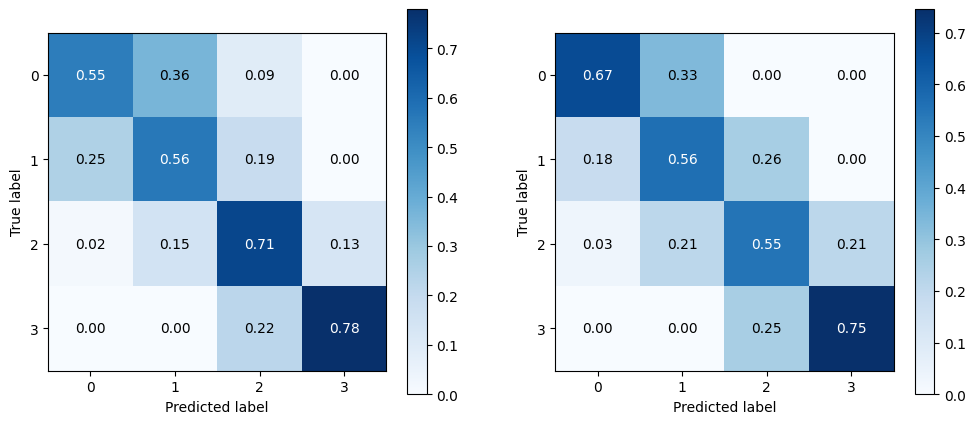

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(pvwmh_results['cv_pred'][2], pvwmh_results['cv_pred'][3], fig, ax1)
plot_confusion_matrix(pvwmh_results['cvs_umap'][2], pvwmh_results['cvs_umap'][3], fig, ax2)

In [51]:
S = 12
ct2 = 0.9
clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                         random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
dwmh_results08 = {}

for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv2, colinear_threshold=0.8, n_splits=S, val_proportion=0.1, target="DWMH", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    dwmh_results08[model_type] = results

clinical_only, 0.29, 0.32
c+volume, 0.5, 0.53
cv_pred, 0.62, 0.7
cvp+samples, 0.62, 0.68
cv_umap, 0.62, 0.66
cvs_umap, 0.62, 0.66
cvps+umap, 0.64, 0.67


In [52]:
S = 12
ct2 = 0.8
clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                         random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
dwmh_results09 = {}

for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv2, colinear_threshold=0.9, n_splits=S, val_proportion=0.1, target="DWMH", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    dwmh_results09[model_type] = results

clinical_only, 0.29, 0.32
c+volume, 0.5, 0.53
cv_pred, 0.62, 0.68
cvp+samples, 0.63, 0.67
cv_umap, 0.61, 0.65
cvs_umap, 0.62, 0.65
cvps+umap, 0.65, 0.68


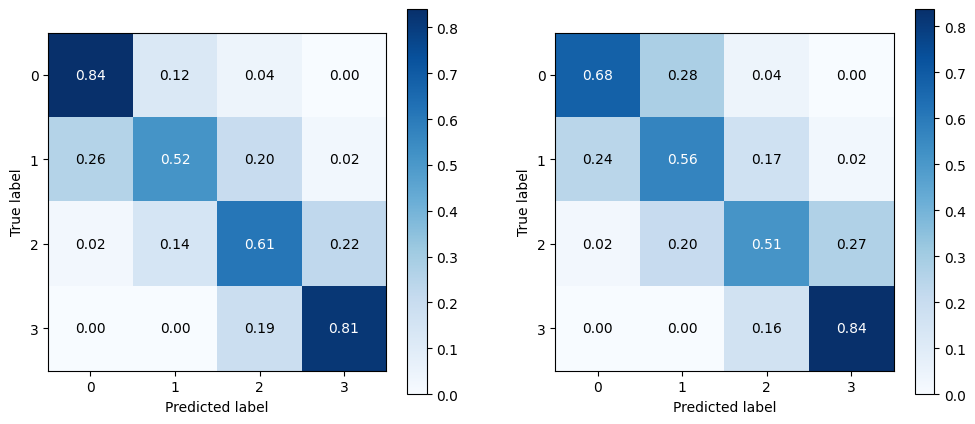

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(dwmh_results08['cv_pred'][2], dwmh_results08['cv_pred'][3], fig, ax1)
plot_confusion_matrix(dwmh_results09['cvs_umap'][2], dwmh_results09['cvs_umap'][3], fig, ax2)

In [54]:
S = 12
ct2 = 0.8
clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                         random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv1, colinear_threshold=ct1, n_splits=S, val_proportion=0., target="scale_stroke", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")

clinical_only, 0.61, 0.59
c+volume, 0.64, 0.65
cv_pred, 0.69, 0.69
cvp+samples, 0.69, 0.7
cv_umap, 0.69, 0.69
cvs_umap, 0.71, 0.71
cvps+umap, 0.7, 0.7


In [55]:
target_fields

['total_fazekas',
 'scale_fazekas',
 'scale_pvs',
 'stroke_les',
 'scale_stroke',
 'dice',
 'f1',
 'avd',
 'recall',
 'deepAtrophy',
 'supAtrophy',
 'WMH',
 'PVWMH',
 'DWMH',
 'BGPVS',
 'CSPVS',
 'micrBld']

In [56]:
S = 6
ct2 = 0.8
clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                         random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv1, colinear_threshold=ct1, n_splits=S, val_proportion=0., target="total_fazekas", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")

clinical_only, 0.17, 0.24
c+volume, 0.35, 0.38


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in 

cv_pred, 0.47, 0.45
cvp+samples, 0.46, 0.44


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(


cv_umap, 0.44, 0.48
cvs_umap, 0.44, 0.47
cvps+umap, 0.48, 0.44


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in 

In [57]:
from sklearn.linear_model import Ridge, BayesianRidge

In [59]:
clinical_fields = ['sbjGroup', 'age', 'sex',
 'diabetes', 'hypertension', 'hyperlipidaemia',
       'smoking_0', 'smoking_1', 'smoking_2']

In [60]:
clinical_fields

['sbjGroup',
 'age',
 'sex',
 'diabetes',
 'hypertension',
 'hyperlipidaemia',
 'smoking_0',
 'smoking_1',
 'smoking_2']

In [61]:
def regression_task(target):

    S = 12

    # clf_reg = BayesianRidge()
    clf_reg = LinearRegression()
    
    all_results = {}

    for model_type in model_types:
        results = run_prediction_new(full_combined_df, model_type, clf=clf_reg, thresholds_dict=thresholdsv2, colinear_threshold=ct2, n_splits=S, val_proportion=0.0, target=target, stratify_target="DWMH", 
                       rescale=True, predict_val=False, verbose=False, metric='rmse', do_log=False, log_feature_matches=log_feature_matches, 
                       rem_colinear_feats=True, colinear_ignores=target_fields, regression=True)
        all_results[model_type] = results
        print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    
    return all_results

In [63]:
age_results = regression_task("age")

clinical_only, 9.9, 9.9
c+volume, 8.6, 8.6
cv_pred, 8.3, 8.3
cvp+samples, 8.2, 8.2
cv_umap, 8.6, 8.6
cvs_umap, 8.7, 8.7
cvps+umap, 8.5, 8.5


In [64]:
sex_results = regression_task("sex")

clinical_only, 0.48, 0.48
c+volume, 0.46, 0.46
cv_pred, 0.47, 0.47
cvp+samples, 0.47, 0.47
cv_umap, 0.45, 0.45
cvs_umap, 0.46, 0.46
cvps+umap, 0.48, 0.48


In [65]:
avd_results = regression_task("avd")

clinical_only, 6.9e+01, 6.9e+01
c+volume, 6.9e+01, 6.9e+01
cv_pred, 7.3e+01, 7.3e+01
cvp+samples, 7.2e+01, 7.2e+01
cv_umap, 7.4e+01, 7.4e+01
cvs_umap, 7.3e+01, 7.3e+01
cvps+umap, 7.6e+01, 7.6e+01


In [66]:
scale_fazekas_results = regression_task("scale_pvs")

clinical_only, 0.47, 0.47
c+volume, 0.45, 0.45
cv_pred, 0.43, 0.43
cvp+samples, 0.43, 0.43
cv_umap, 0.44, 0.44
cvs_umap, 0.44, 0.44
cvps+umap, 0.45, 0.45


### Quality control via dice prediction

In [67]:
dice_results = regression_task("dice")

clinical_only, 0.17, 0.17
c+volume, 0.14, 0.14
cv_pred, 0.098, 0.098
cvp+samples, 0.098, 0.098
cv_umap, 0.093, 0.093
cvs_umap, 0.093, 0.093
cvps+umap, 0.091, 0.091


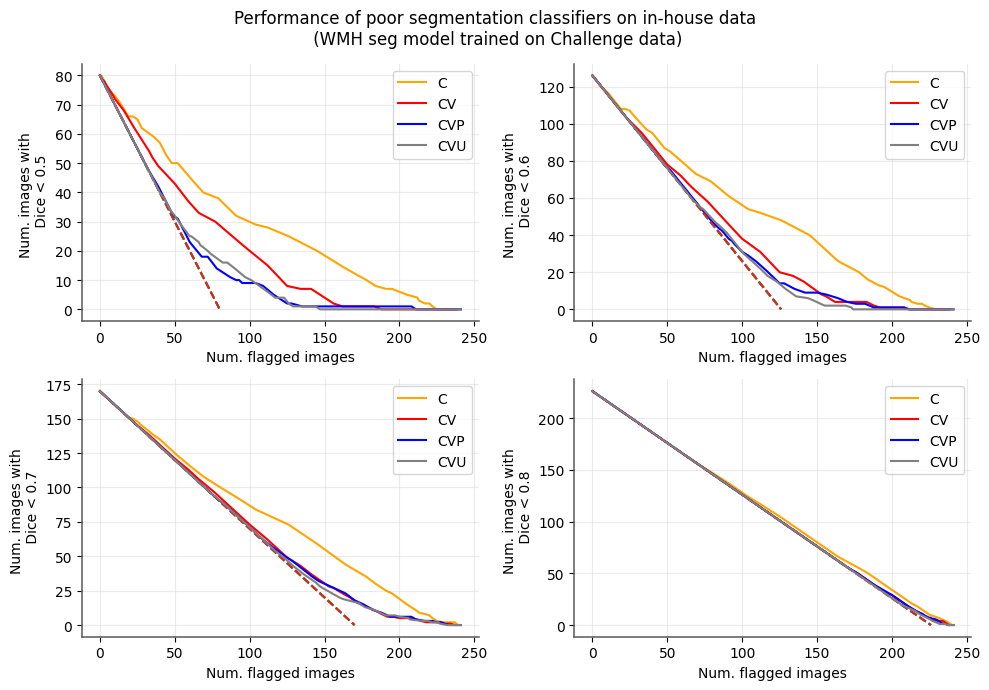

In [69]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))

name_key = {'clinical_only':'C', 'c+volume':'CV', 'cv_pred':'CVP', 'cv_umap':'CVU'}
colour_key = {'clinical_only':'orange', 'c+volume':'red', 'cv_pred':'blue', 'cv_umap':'grey'}

for ax, dice_thresh in zip(axs.flatten(), [0.5, 0.6, 0.7, 0.8]):
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=0)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=0)
    
    for method in ['clinical_only', 'c+volume', 'cv_pred', 'cv_umap']:
        # method = 'clinical_only'
        target = dice_results[method][2]
        pred = dice_results[method][3]

        bad_images = target < dice_thresh
        num_bad_images = bad_images.sum()

        ax.plot([0, num_bad_images], [num_bad_images, 0], linestyle='dashed')

        thresholds = torch.arange(0, 1, 0.01)

        xs = []
        ys = []

        for t in thresholds:
            flagged_images = pred < t
            num_flagged_images = flagged_images.sum()
            remaining_bad_images = bad_images * (torch.logical_not(flagged_images))
            num_remaining_bad_images = remaining_bad_images.sum()

            ys.append(num_remaining_bad_images)
            xs.append(num_flagged_images)

        ax.plot(xs, ys, label=name_key[method], c=colour_key[method])
        ax.set_ylabel(f"Num. images with \n Dice < {dice_thresh}")
        ax.set_xlabel("Num. flagged images")
        ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
        ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
        ax.spines[['left', 'bottom']].set_color('#585858')
        # break
    ax.legend()
fig.tight_layout()

plt.suptitle("Performance of poor segmentation classifiers on in-house data\n (WMH seg model trained on Challenge data)")
fig.tight_layout()

plt.savefig("qual_control_CVD_with_challenge.pdf")

### saving the models for the generalization test

In [160]:
def compute_accuracy_classification(clf, X, y):
    y_hat = clf.predict(X)
    y_target = y
    
    accuracy = accuracy_score(y_target, y_hat)
    # print(accuracy)
    accuracy = (y_hat == y_target).mean()
    # print(accuracy)

    class_preds = defaultdict(list)
    for yi in range(len(y_target)):
        yi_gt = y_target[yi]
        yi_hat = y_hat[yi]
        class_preds[yi_gt].append(yi_hat)
    # print(class_preds)
    class_preds = {yi: torch.Tensor(preds) for (yi, preds) in class_preds.items()}
    # print(class_preds)
    class_accs = [(preds == yi).sum().item()/preds.shape[0] for (yi, preds) in class_preds.items()]
    balanced_accuracy = torch.Tensor(class_accs).mean().item()
    
    return accuracy, balanced_accuracy, y_target, y_hat

In [42]:
def compute_accuracy_regression(clf, X, y):
    y_hat = clf.predict(X)
    y_target = y
    
    return np.mean(np.abs(y_target - y_hat)), 0.

In [43]:
def train_final_model(df, model_type, thresholds_dict, clf, target="DWMH", label_categories=target_fields, 
                   rescale=True, do_log=False, log_feature_matches=None, 
                   rem_colinear_feats=False, colinear_threshold=0.8, colinear_ignores=target_fields, regression=False, stratify_target=None):
    verbose=False
    df = df.copy() # just to make sure I don't accidently modify the original at any point.
    
    # create the training data df
    df = load_model_df(df, model_type, **thresholds_dict)
    
    # run preprocessing on the data
    #df = shuffle(df)
    #print(df.keys().values)
    if do_log:
        df = shift_and_log_features(df, log_feature_matches, verbose=verbose)
    if rem_colinear_feats:
        remaining_keys = create_minimal_correlation_keys(df, ignore_keys=colinear_ignores, threshold=colinear_threshold, verbose=verbose)
        df = df[remaining_keys + colinear_ignores]
    X, y = extract_Xy(df, target, verbose, kept_column=stratify_target, label_categories=label_categories)
    X = X.reset_index()
    
    rescaler = None
    if rescale:
        rescaler = Rescaler()
        rescaler.fit(X)
        X = rescaler.predict(X)
    
    clf.fit(X, y)
    
    return X, y, clf, rescaler, remaining_keys

In [73]:
def load_and_evaluate_model(clf, rescaler, df, model_type, remaining_keys, target="DWMH", label_categories=target_fields, 
                   rescale=True, do_log=False, log_feature_matches=None, 
                   rem_colinear_feats=False, colinear_ignores=target_fields, regression=False, stratify_target=None):
    verbose=False
    df = df.copy() # just to make sure I don't accidently modify the original at any point.
    
    # create the training data df
    #df = load_model_df(df, model_type, **thresholds_dict)
    
    key_replace = {"AGE": "age", "PTGENDER": "sex"}
    columns = df.columns
    for new_key, key in key_replace.items():
        if key in columns:
            df[new_key] = df[key]
            df.drop(columns=key)
    
    # run preprocessing on the data
    #df = shuffle(df)
    #print(df.keys().values)
    if do_log:
        df = shift_and_log_features(df, log_feature_matches, verbose=verbose)
        
    if rem_colinear_feats:
        df = df[remaining_keys + colinear_ignores]
        
    # print("BEFORE HAND -----------")
    # print(df.keys())
    X, y = extract_Xy(df, target, verbose, kept_column=stratify_target, label_categories=label_categories)
    X = X.reset_index()
    # print("AFTER -----------------")
    # print(X.keys())
    
    if rescale:
        X = rescaler.predict(X)
    
    if regression:
        return compute_accuracy_regression(clf, X, y)
    else:
        return compute_accuracy_classification(clf, X, y)

In [45]:
import pickle

In [46]:
thresholdsv1 = {
    "ent1_t":0.45,"ent2_t":0.1,"ent3_t":0.1,"pred1_t":0.3,"pred2_t":0.3,"pred3_t":0.6
}
ct1 = 0.7 # for PVWMH

thresholdsv2 = {
    "ent1_t":0.45,"ent2_t":0.3,"ent3_t":0.45,"pred1_t":0.1,"pred2_t":0.3,"pred3_t":0.1
}
ct2 = 0.8 # for DWMH

In [62]:
def train_and_save_model(filename, target, thresholds_dict, colinear_threshold, stratify_target=None, regression=False):
    
    model_data = {}
    model_types = ["clinical_only","c+volume","cv_pred", "cv_pred0.5", "cvp+samples", "cv_umap", "cvs_umap","cvps+umap"]

    # PVWMH
    for model_type in model_types:
            if regression:
                clf = LinearRegression()
            else:
                clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                                     random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

            X, y, clf, rescaler, remaining_keys = train_final_model(full_combined_df, model_type, clf=clf, thresholds_dict=thresholds_dict, colinear_threshold=colinear_threshold, 
                                                                    target=target, rescale=True,  do_log=False, log_feature_matches=log_feature_matches, 
                           rem_colinear_feats=True, colinear_ignores=target_fields, regression=regression, stratify_target=stratify_target)

            model_data[model_type] = {"clf":clf, "rescaler": rescaler, "remaining_keys": remaining_keys}

            if not regression:
                acc, balanced_acc = compute_accuracy_classification(clf, X, y)
                print(f"{model_type}: {acc:.2}, {balanced_acc:.2}")
            else:
                mae, _ = compute_accuracy_regression(clf, X, y)
                print(f"{model_type}: {mae:.2}")
                
    with open(f'saved_models/{filename}.model', 'wb') as handle:
        pickle.dump(model_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'saved_models/{filename}.model', 'rb') as pickle_file:
        content = pickle.load(pickle_file)

    print("\nassess that saved model has the same performance")

    for key in content:
        data = content[key]
        acc, balanced_acc = load_and_evaluate_model(data['clf'], data['rescaler'], full_combined_df, model_type=key, remaining_keys = data['remaining_keys'],
                       target=target, label_categories=target_fields, 
                       rescale=True, do_log=False, log_feature_matches=None, 
                       rem_colinear_feats=True, colinear_ignores=target_fields, regression=regression, stratify_target=stratify_target)
        print(f"{key}: {acc:.2}, {balanced_acc:.2}")

In [151]:
# clinical_fields = ['sbjGroup', 'age', 'sex',
#  'diabetes', 'hypertension', 'hyperlipidaemia',
#        'smoking_0', 'smoking_1', 'smoking_2']
# ICV is a bad feature that breaks things!!!
clinical_fields = ['sex']

In [152]:
train_and_save_model('CHAL_BASED_CVD_PVWMH', target="PVWMH", thresholds_dict = thresholdsv1, colinear_threshold = ct1)

clinical_only: 0.22, 0.3
c+volume: 0.49, 0.63
cv_pred: 0.7, 0.75
cv_pred0.5: 0.66, 0.72
cvp+samples: 0.69, 0.74
cv_umap: 0.69, 0.73
cvs_umap: 0.68, 0.73
cvps+umap: 0.72, 0.77

assess that saved model has the same performance
clinical_only: 0.22, 0.3
c+volume: 0.49, 0.63
cv_pred: 0.7, 0.75
cv_pred0.5: 0.66, 0.72
cvp+samples: 0.69, 0.74
cv_umap: 0.69, 0.73
cvs_umap: 0.68, 0.73
cvps+umap: 0.72, 0.77


In [153]:
train_and_save_model('CHAL_BASED_CVD_DWMH_0.8', target="DWMH", thresholds_dict = thresholdsv2, colinear_threshold = 0.8)

clinical_only: 0.25, 0.34
c+volume: 0.52, 0.58
cv_pred: 0.69, 0.74
cv_pred0.5: 0.66, 0.72
cvp+samples: 0.67, 0.73
cv_umap: 0.69, 0.75
cvs_umap: 0.68, 0.75
cvps+umap: 0.74, 0.78

assess that saved model has the same performance
clinical_only: 0.25, 0.34
c+volume: 0.52, 0.58
cv_pred: 0.69, 0.74
cv_pred0.5: 0.66, 0.72
cvp+samples: 0.67, 0.73
cv_umap: 0.69, 0.75
cvs_umap: 0.68, 0.75
cvps+umap: 0.74, 0.78


In [154]:
train_and_save_model('CHAL_BASED_CVD_DWMH_0.9', target="DWMH", thresholds_dict = thresholdsv2, colinear_threshold = 0.9)

clinical_only: 0.25, 0.34
c+volume: 0.52, 0.58
cv_pred: 0.7, 0.76
cv_pred0.5: 0.66, 0.72
cvp+samples: 0.71, 0.77
cv_umap: 0.67, 0.74
cvs_umap: 0.68, 0.75
cvps+umap: 0.76, 0.8

assess that saved model has the same performance
clinical_only: 0.25, 0.34
c+volume: 0.52, 0.58
cv_pred: 0.7, 0.76
cv_pred0.5: 0.66, 0.72
cvp+samples: 0.71, 0.77
cv_umap: 0.67, 0.74
cvs_umap: 0.68, 0.75
cvps+umap: 0.76, 0.8


In [155]:
train_and_save_model('CHAL_BASED_CVD_total_fazekas', target="total_fazekas", thresholds_dict = thresholdsv1, colinear_threshold = ct1)

clinical_only: 0.17, 0.26
c+volume: 0.36, 0.47
cv_pred: 0.57, 0.61
cv_pred0.5: 0.53, 0.59
cvp+samples: 0.58, 0.64
cv_umap: 0.53, 0.62
cvs_umap: 0.55, 0.62
cvps+umap: 0.6, 0.65

assess that saved model has the same performance
clinical_only: 0.17, 0.26
c+volume: 0.36, 0.47
cv_pred: 0.57, 0.61
cv_pred0.5: 0.53, 0.59
cvp+samples: 0.58, 0.64
cv_umap: 0.53, 0.62
cvs_umap: 0.55, 0.62
cvps+umap: 0.6, 0.65


In [157]:
#train_and_save_model('CHAL_BASED_CVD_age', target="age", thresholds_dict = thresholdsv1, colinear_threshold = ct1, regression=True)

In [158]:
train_and_save_model('CHAL_BASED_CVD_sex', target="sex", thresholds_dict = thresholdsv1, colinear_threshold = ct1, regression=True)

clinical_only: 0.45
c+volume: 0.43
cv_pred: 0.41
cv_pred0.5: 0.42
cvp+samples: 0.41
cv_umap: 0.39
cvs_umap: 0.39
cvps+umap: 0.39

assess that saved model has the same performance
clinical_only: 0.45, 0.0
c+volume: 0.43, 0.0
cv_pred: 0.41, 0.0
cv_pred0.5: 0.42, 0.0
cvp+samples: 0.41, 0.0
cv_umap: 0.39, 0.0
cvs_umap: 0.39, 0.0
cvps+umap: 0.39, 0.0


### evaluating the models trained on the on the ADNI dataset

In [159]:
def load_and_save_all_models(filename, target, stratify_target=None, regression=False, seg_eval_ds="CVD"):
    with open(f'saved_models/{filename}.model', 'rb') as pickle_file:
        content = pickle.load(pickle_file)

    model_type_name_map = {"clinical_only":"C","c+volume":"CV","cv_pred":"CVP", "cv_pred0.5":"CVP0.5", "cvp+samples":"CVPS", "cv_umap":"CVH", "cvs_umap":"CVSH","cvps+umap":"CVPSH"}
        
    print("\nassess that saved model has the same performance")

    model_results = {}
    
    for key in content:
        data = content[key]
        #print(data['remaining_keys'])
        acc, balanced_acc, targets, preds = load_and_evaluate_model(data['clf'], data['rescaler'], full_combined_df, model_type=key, remaining_keys = data['remaining_keys'],
                       target=target, label_categories=target_fields, 
                       rescale=True, do_log=False, log_feature_matches=None, 
                       rem_colinear_feats=True, colinear_ignores=target_fields, regression=regression, stratify_target=stratify_target)
        print(f"{key}: {acc:.2}, {balanced_acc:.2}")
        model_results[key] = (acc, balanced_acc, targets, preds)
        
#         with open("generalization_tests_results.csv", "a") as f:
#             model_name = model_type_name_map[key]
            
#             if "CHAL" in filename:
#                 wmh_seg_train_ds = "WMH Challenge"
#             else:
#                 wmh_seg_train_ds = "CVD"
                
            
#             if "ADNI" in filename:
#                 fazekas_pred_ds = "ADNI"
#                 fazekas_eval_ds = "CVD"
#             else:
#                 fazekas_pred_ds = "CVD"
#                 fazekas_eval_ds = "ADNI"
                
            #f.write(f"{model_name}, {wmh_seg_train_ds}, {fazekas_pred_ds}, {fazekas_eval_ds}, {seg_eval_ds}, {target}, {filename}, {acc:.2}, {balanced_acc:.2}\n")
    return model_results

In [101]:
load_and_save_all_models("ADNI_PVWMH", "PVWMH", seg_eval_ds="WMH_Challenge")


assess that saved model has the same performance
clinical_only: 0.24, 0.25
c+volume: 0.26, 0.27
cv_pred: 0.25, 0.26
cv_pred0.5: 0.4, 0.39
cvp+samples: 0.42, 0.41
cv_umap: 0.24, 0.25
cvs_umap: 0.24, 0.25
cvps+umap: 0.26, 0.25


In [102]:
load_and_save_all_models("ADNI_DWMH_0.8", "DWMH", seg_eval_ds="WMH_Challenge")


assess that saved model has the same performance
clinical_only: 0.18, 0.25
c+volume: 0.21, 0.25
cv_pred: 0.24, 0.3
cv_pred0.5: 0.18, 0.25
cvp+samples: 0.21, 0.25
cv_umap: 0.21, 0.25
cvs_umap: 0.21, 0.25
cvps+umap: 0.21, 0.25


In [103]:
load_and_save_all_models("ADNI_DWMH_0.9", "DWMH", seg_eval_ds="WMH_Challenge")


assess that saved model has the same performance
clinical_only: 0.18, 0.25
c+volume: 0.21, 0.25
cv_pred: 0.21, 0.25
cv_pred0.5: 0.28, 0.36
cvp+samples: 0.22, 0.25
cv_umap: 0.21, 0.26
cvs_umap: 0.22, 0.26
cvps+umap: 0.21, 0.25


In [104]:
load_and_save_all_models("ADNI_total_fazekas", "total_fazekas", seg_eval_ds="WMH_Challenge")


assess that saved model has the same performance
clinical_only: 0.15, 0.14
c+volume: 0.15, 0.14
cv_pred: 0.15, 0.14
cv_pred0.5: 0.15, 0.14
cvp+samples: 0.17, 0.16
cv_umap: 0.16, 0.15
cvs_umap: 0.16, 0.15
cvps+umap: 0.19, 0.21


In [105]:
load_and_save_all_models("ADNI_sex", "PTGENDER", regression=True, seg_eval_ds="WMH_Challenge")


assess that saved model has the same performance
clinical_only: 5.6, 0.0
c+volume: 2.7, 0.0
cv_pred: 3.7, 0.0
cv_pred0.5: 2.5, 0.0
cvp+samples: 3.5, 0.0
cv_umap: 5.7, 0.0
cvs_umap: 5.9, 0.0
cvps+umap: 5.2, 0.0


### Evaluate the models trained with the WMH Challenge uncertainty maps

In [106]:
load_and_save_all_models("CHAL_BASED_ADNI_PVWMH", "PVWMH", seg_eval_ds="WMH_Challenge")


assess that saved model has the same performance
clinical_only: 0.24, 0.25
c+volume: 0.26, 0.27
cv_pred: 0.25, 0.26
cv_pred0.5: 0.4, 0.39
cvp+samples: 0.41, 0.41
cv_umap: 0.24, 0.25
cvs_umap: 0.25, 0.26
cvps+umap: 0.26, 0.25


In [107]:
load_and_save_all_models("CHAL_BASED_ADNI_DWMH_0.8", "DWMH", seg_eval_ds="WMH_Challenge")


assess that saved model has the same performance
clinical_only: 0.18, 0.25
c+volume: 0.21, 0.25
cv_pred: 0.24, 0.3
cv_pred0.5: 0.18, 0.25
cvp+samples: 0.21, 0.25
cv_umap: 0.21, 0.25
cvs_umap: 0.21, 0.25
cvps+umap: 0.21, 0.25


In [108]:
load_and_save_all_models("CHAL_BASED_ADNI_DWMH_0.9", "DWMH", seg_eval_ds="WMH_Challenge")


assess that saved model has the same performance
clinical_only: 0.18, 0.25
c+volume: 0.21, 0.25
cv_pred: 0.21, 0.25
cv_pred0.5: 0.28, 0.36
cvp+samples: 0.21, 0.25
cv_umap: 0.21, 0.26
cvs_umap: 0.22, 0.26
cvps+umap: 0.21, 0.25


In [109]:
load_and_save_all_models("CHAL_BASED_ADNI_total_fazekas", "total_fazekas", seg_eval_ds="WMH_Challenge")


assess that saved model has the same performance
clinical_only: 0.15, 0.14
c+volume: 0.15, 0.14
cv_pred: 0.15, 0.14
cv_pred0.5: 0.15, 0.14
cvp+samples: 0.19, 0.19
cv_umap: 0.16, 0.15
cvs_umap: 0.17, 0.16
cvps+umap: 0.18, 0.2


In [110]:
load_and_save_all_models("CHAL_BASED_ADNI_sex", "PTGENDER", regression=True, seg_eval_ds="WMH_Challenge")


assess that saved model has the same performance
clinical_only: 5.6, 0.0
c+volume: 2.7, 0.0
cv_pred: 3.7, 0.0
cv_pred0.5: 2.5, 0.0
cvp+samples: 3.5, 0.0
cv_umap: 5.7, 0.0
cvs_umap: 5.7, 0.0
cvps+umap: 5.4, 0.0
